In [44]:
from pydub import AudioSegment
import numpy as np
import IPython
import matplotlib.pyplot as plt
import scipy, pylab
%matplotlib inline

### Utilities

In [80]:
def int_ceil(a,b):
    return (a+b-1)//b

def stft(x, fs, framesz, hop):
    framesamp = int(framesz*fs)
    hopsamp = int(hop*fs)
    w = scipy.hamming(framesamp)
    X = scipy.array([scipy.fft(w*x[i:i+framesamp]) 
                     for i in range(0, len(x)-framesamp, hopsamp)])
    return X

def istft(X, fs, T, hop):
    x = scipy.zeros(T*fs)
    framesamp = X.shape[1]
    hopsamp = int(hop*fs)
    for n,i in enumerate(range(0, len(x)-framesamp, hopsamp)):
        x[i:i+framesamp] += scipy.real(scipy.ifft(X[n]))
    return x

### File Input

In [265]:
class Sound(object):
    def __init__(self, sound, framerate):
        self.sound = sound
        self.rate  = framerate
        
    @classmethod
    def from_mp3(cls, path, start = 0, seconds = None):
        audiofile = AudioSegment.from_file(path)
        assert(audiofile.frame_rate == 44100)
        data = np.fromstring(audiofile._data, np.int16)
        
        channeled_music = data.reshape(len(data) / 2, 2).T
        
        left   = channeled_music[0]
        right  = channeled_music[1]
        
        mono = left#((left + right) / 2).astype(np.int16)
        
        if start != 0 or seconds is not None:
            if seconds is not None:
                segment = slice(
                    start * audiofile.frame_rate,
                    (start + seconds) * audiofile.frame_rate
                )
            else:
                segment = slice(
                    start * audiofile.frame_rate,
                    None
                )
            mono = mono[segment]
        return cls(mono, audiofile.frame_rate)
    
    @classmethod
    def from_spectrogram(cls, spectrogram, frame_seconds, frame_rate = 44100):
        # window used for fft
        frame_len = spectrogram.shape[1] * 2
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        
        num_windows = spectrogram.shape[0]
        
        frame = 0
        data = np.zeros(num_windows * frame_len)
        
        for t in range(0, spectrogram.shape[0] * frame_len, frame_len):
            iffted = np.fft.ifft(np.concatenate([spectrogram[frame], spectrogram[frame][::-1]]))
            iffted = np.real(iffted)
            iffted /= smoothing_window
            
            data[t:t+frame_len] = iffted
            frame += 1
            
        return Sound(data.astype(np.int16), frame_rate)
    
    def short_time_fft(self, frame_seconds):
        # window used for fft
        frame_len = int(self.rate * frame_seconds)
        if frame_len % 2 == 1:
            frame_len += 1
        # use a hamming window of the same size
        smoothing_window = np.hamming(frame_len)
        # store the frequencies inside big matrix
        num_windows = len(self.sound) // frame_len
        
        spectrogram = np.zeros((num_windows, frame_len//2), np.complex64)
        for frame in range(0, num_windows):
            t = frame * frame_len
            sample = self.sound[t:t+frame_len]
            ffted  = np.fft.fft(smoothing_window * sample)[0:frame_len//2]
            spectrogram[frame] = ffted
            
        return spectrogram
    
    def _repr_html_(self):
        return IPython.display.display_html(IPython.display.Audio(self.sound, rate=self.rate))

In [258]:
trumpets =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3", 21.5, 3)

In [259]:
begin =  Sound.from_mp3("/Users/jonathanraiman/Desktop/Music/F00/IHZE.mp3", 0, 3)

In [264]:
tstep = 0.5
Sound.from_spectrogram(filename.short_time_fft(tstep), tstep)

<source src="data:audio/wav;base64,UklGRqxYAQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YYhYAQDp/J7+Ef8QAGkAtgBLAa0B4AHTASEBZgCf/8D9/Pyw/QH9MPxN/Er8yftC+sf61/1L/1wAWgHHAAMB+QEhAlUBewDXAMYB/gFfAS0B9wBEAL8AVQHnAKgAKwFCAuwCHAO+A58EYwXTBRoFBAQHAwwCVgOUBZAFngNcAfQA/gFgA5UEwQRWBG8C7ABdAX4BMAEZACz/tP9mABQBNgEHARMBDAGrAUsCEQLiARECtgE4ARwBuAAtAMv/lgC9AkgEGQQKA7gCjAKpAu8DGQR3At8A8QA+AqQCZQJdAo8CwwI+AtABbAJWAx8EHQX4BSUGLAY5BgoGEgavBQwEkQKgAdUA0AB3AOf/cgCHATgC6gE+AXIAZf/0/qb+bP6O/pH+0P4r/8b+u/0g/W79yP1x/WH94P2p/UD9efzH+4z8nfwr/FH8Hvzp+7r6U/k0+QD5VPgN+Lb4HPmX+DH4SfiA+Y77X/1K/nL+Qf+7/7H+Zf5j/zgAxwBlAR4CVwI5An0ClwKjAicDYAPGAloCZwITAsMBMgE3AGP/bf76/dL9Q/4+/yH/Jv9g/2//qf8t/gj80fqA+Uv4j/eE9sP1O/bR9kP3Kvht+YP6bvrU+Tn5zPjE+Pr4wvrx/Mf94v2m/M/6J/pU+qz6fPuw/KX96f3h/I37bPsA/Ej89vuz+zP8ev3g/kv/Cv+W/kD9jftW+sH5Lfrw+jf7PPuT+5P85fw1/Ob7T/wb/X/96f2K/oL+hv7O/k7/8v8rAK0ADAGuAOD/6P7i/qn/MAB3AO4AlgExAsoCIQMnA3ADNwSCBNEDHgPsAmMDQATOBC8FfwV6BQ8F2ARRBdwF3AU2BU4EjwMFA5cC2AEhAdAAcgBCADAAIACBAIEAMwDFADoBBgG9AKsALgG2AQ8CUAI9AmwCZAKZAfIAzQDyAAYB5ACEAA4A2//L/57/Fv+r/s7+sP4L/uL9iv71/pn+8f2B/TD9T/xm+y/7P/uB+7z7oPuw+xv8jPw1/Zb+DADPABkBTwGHAe8BaAIpAloBSgHTAdABegGZARYCjALIAvQC6AJXAiwChAKbArUCygLFAooCPQJNAjkCRgLLAgoDxgJIAgQCxgFpAYkBugGpAd0BEwIZAjYCWAJsAlACMAKOAuMCvgKkArECtQKPAmACWAJCAiMCAgLFAaYBoQFYAQEBCQETAewA5ADhALMAfABpACIAh/8c/+/+s/5y/oH+rv5n/tr9qP0G/nr+rP6s/on+oP7i/sP+lv7D/v/+9f7O/vz+Tv9j/1r/Vf+K/8X/hf9I/2j/l/+x/6T/lP+c/5r/fP9f/5T/4//w/9P/tv+w/47/Xf8k/93+uf6M/o7+u/6J/mz+k/5n/v793f0O/iP+M/49/lD+nP6z/pf+mf6K/lD+Qv6m/g7/Mf8x/z3/jv/d/wYAOABUAGkA2gB+AY8BQgE7AYcB0wGzAWUBMgHhAJgAVAAIAOr/AQATAN3/rv/j/wYA5f/6/1cAzwA6AV0BbwG2AR4CVwJOAm0CiQJ5ApYC0gLLAooCoQLgApsCTgKCAuICDAPtAt0C+gLqArgCtQLSAv8CIQMKAzMDrgPLA5wDgQOCA6kDqQN3A1YDMAMEA9cCwQLIAocCSwJsAnUCTgIeAgwCJgLtAYEBZwFyAW0BQAHhAJkAjACdAKMAoQCdAI4AyAABAfQAFgEcAf8AFAEWASABSAFUAVQBXQFqAWoBQAEcAU0BjgGTAWoBRQFSAWQBZAFfAVUBIQGUACsANQBEADcAGwDe/5T/lv+8/4z/OP8X/yj/LP/5/uD+9/79/vL+6P7n/v3+9P6G/lD+m/6w/mT+B/7L/bv9w/3K/bj9hv1p/Zj9wP2+/aP9fv2U/cf93P3V/an9k/2G/Uj9Hf0w/V39b/1V/Tb9DP3H/Mf85fzA/JP8Vfz5+7f7p/u4+6D7jfuI+2H7Y/tj+0/7PfsT+wj7CfsD+wj77vrf+uP6zPrR+gD7I/sq+wH7APtc+7P7Dvx//Nz8C/0H/Sn9b/2h/c/93f3g/er9/v0O/uX9uv29/d/9Af4B/hH+QP5D/vL9if1U/Uf9Qv0z/TX9d/3I/dT9q/2y/Rb+Zf5i/lP+Yv5+/nz+b/5s/kL+E/4e/j7+Xf5i/i3+x/1V/fT8bvz5+wb8GPzv+yr8u/ww/Wf9f/2w/d/9Fv5P/l/+k/7S/vf+Qf9//47/rv/b/+D/w/+x/6n/ff8r/xH/Ev/T/qT+nP5+/kr+QP6B/tD+Bv8m/z7/kf8MAIQACwF5Ab4BIAJ6ArMCAgNLA5QD1gP/AxkE5QPTAx4ELgQcBA0E9wPgA6MDlAPIA7EDaAM0A/cC4ALnAqkCPgL/ASkCPQL8AQECMQIWAvkBRQKxAowCXwLQAgEDpAKwAisDPQMEAykDUgP5AsAC9ALlArACxgK+AmICLAJfAmUCGQJCArkCtQLAAiYDDwPiAnADQASpBJkExgQPBcsE0AQxBSQF1QSHBHcEYwQKBPAD2gOrA+ID5QNjA/UC2wL3AssCiQKuAnwCFAIgAiQCFwL/AcMBoAGOAb0B5QF0AfIA1QDQAKEAhgDCAMIAMwDJ/4z/Rv8h/9/+ef4B/qX9kP1I/dn8jPxx/JX8w/wM/Wf9sv0W/lz+f/6w/tv+Ef9V/5H/xv8OAEgAdwCwAJ4AgwB/AF0AUAAZAMH/uf+r/3z/df9v/3X/o//T//X/2P+n/6H/Sv/O/r7+tv6M/rv+Wv/N/8j/7/+TAAYB3wDCACgBqQEBAlcCfAJDAjAChAK9AtICIQNWAxQDpgJTAhYCJgJ6AnoCCgLsAV8CZQIWAncCxgKhAvcCawMRA5ICFgPeA9UDvgMrBEAE5QP4A1UEUQQxBGMEQwSZA3ADxgORAxkDWgPLA1gD9AJjA0UDmwKxAvoCsQKSAuoCBAO7AuICkQOrA3UD/QN1BDsEGgSEBJIEyAOjA14EQASsA+UDBwROA4QCFwJ/AaEAEwDT/0j/zv78/kr/Pf9W/8v/8P/t/2oA/wA4AW8B/gFfAjUCWwIEAzgD/wIeA1IDEgPOAvUCBwOjAm0CjgJDAt0B9wEOAsABlAHNAakBQgFyAa4BIwGzACsBMwFvAHEAzwBPALT/uf/G/33/gf+8/07/kf6x/lj/O//G/v/+Kf90/sr9z/2O/c/8fvxf/Kr7Afv9+uT6n/qq+hr7jfuW+9X7e/za/C39rv3p/bD95f2R/p7+av6h/v/+H/8X/07/K/+g/nT+fv5v/hH+mP1V/fz8gfwo/Ab8xPtv+4D7xPvp+6j7KPuy+hP6pfmq+dH5Bvpk+sr6+/pH+8z7EPwO/DL8m/y//KX8//xD/c38L/zp+6/7Fft2+jn6+fng+UT6kvqF+qr6RPvK++L7N/za/C39Xf24/UL+5f5l/67/vv/q/2kAyADCAK4AwwCyAIsAdwD6/0D/8P7i/sL+lv6J/lz+1/2g/bv9bP0D/dz8wPyV/Hz8iPyQ/KX87Pw1/U39ZP2e/aP9b/15/cX9//0H/gz+If76/cP97f0u/iT+DP7Q/XH9ef2Z/b39WP4o/wAAyABVAb4BFwKUAgwDUwO5AxwELgRYBLEElAQkBA0ENwQPBJoDoQOmAwEDtgLyAvQC1QL8AjYD0gJQAkoC8QFCARMBfAGhATgBNQFSAQQBSAECAhkC0wHqAUgCbwJ/At8CDwPNAtcCKwMCA8MCGQNbAxwDCQNDAzkD/wIBA/cCZAKoAZYB9AExAtMC0ANbBKcEAAUpBRAFMgW+BegFuQUDBpAGEweOB+kH8weWB5sHCwj+B/sHbAirCLAIvAi9CKoImwi/CNIIugjvCDAJ1wg6CAAI+QfRB8QHxQdmB/kGzgZwBowFcgTWA6EDgQO2A/ID0wOBAzsDLAP9AocC1QHdAOL/Ef+b/vn94vwT/

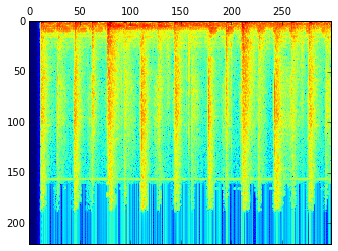

In [231]:
plt.matshow(np.log1p(np.abs(begin.short_time_fft(0.01).T)))

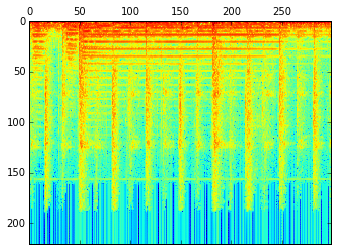

In [230]:
plt.matshow(np.log1p(np.abs(trumpets.short_time_fft(0.01).T)))

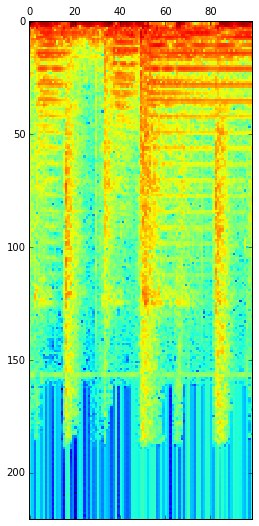

In [174]:
plt.matshow(np.log1p(np.abs(filename.short_time_fft(0.01).T)));

In [238]:
tstep2 = 0.2

begin_trumpets = ((trumpets.short_time_fft(tstep2) + begin.short_time_fft(tstep2)) / 2.0)

Sound.from_spectrogram(begin_trumpets, tstep2)

<source src="data:audio/wav;base64,UklGRrwJBABXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YZgJBACs59cBQwVOCdgJYAkcCQII/An7DQIQ0A/HCvwE/wZ0EJYV1Q99DNwNcwuEC5kN+A2ZEVMUYg8xC7wQ9RZOFiYT8BKGF5YYXRToEWoQExKJF9YahBrHFxMWhRX/ErgS/xeRG4kYHRWGEyMSLBYVG10YYxZcGdAcrSBlH0Ib9h0iIx0niCrzK6Yr5SglJ0UorislMLAu9CrpKcMnJifbJ9MoxCowKQ8lxCGBIqQlqSMkIzgnjydxJ50mCyX0KgwuwieuI0IjlyTgJXciCyBJIVIfjRs4G3Ubbxu2GzsZkBdeFT8Png8CFUYSzgnrBlEKfQqkB0IGjwYgCQMGqQBaA7kDKgCi/bH4Kvm5/O34UfXi9fz2XfeQ8+DuI++O71zrvOok8zr4fPLx6r3oSuty7DvqZOuh7hzs8OWO43bltefS5+DkM+IN4tfiqOVX6IbnEuZO59rrte296VHnYuiz6jDrtOeq5z3piOdV6HLoNOjk6gDpheUm5ZvmZujg4/fe1uBB4ebeJ9zG2GbYB9kz14zV8dJm0EzSh9EszCrJB8YDxO3EOsUDxmvFisTSwl27dbkRwMXB8r8mvz6+bL+EwI7AgcEzwTnBgMNIxM/CkcPaxTLDe8FKxmTIGsdtxcDDFMdfykjJlsiIyF3JL8t2yqDJoswmzSbLx8ykzSnRotYh1EzSONSe1X/a4d6S3gjaktiL3h/fsdnm2APbnduY2crXQNcZ1iDY2dwC3ojcetvB2xjeWN9V37PhjOQ85aLiDeCj45zpvuyn7Gjq+ute72LwMvYN/C/6nfno+gz9ZgPNA68A1ANfB1UKrAq3BhIGFwbYBg8NgA+KDicSDRIBDTALUwoGCqAJiAebBlUFdAgZD6INmQgaCecO0A/FCDsJlQ/DEbkSWhWmGwcdYBhgGrAgxiWLJjQmnCulK3snfCqzLUAwozFsLbArDC4aMss0WC/yLGozbzT8MPwxLjWxNjc1BTN2Mmkx+i6XLqsuhCwlLdQs7ib7I4gkCST2IZcdlhqgGL0XQRyUHgYYbBLGFQMZZxQqE44Y/xayEPIQABTQEwwTehNhE0ESgw+UDtcRtRPhFBQVERODFxwcHhvHHdkg/yDNIKQiHiY/Iu4dWyMeKTgpQyemJrcmhyaHJekjPyOoIo4lZiX9H6gjPSWdHVQXOhPjGOIc6hSqEmoV2hSxEN0OWRRkFAQPDw6GDhYLkgRIA+EENASwAzQBBv4c+v34TP5t/hf7dvu2+bz41Plq+Zv5jPeS9Dv2vvbw9Zz4IPcn8tfyrvW39vf0/vCj8jP3//XO8wfziPDc78/yWPWR9B3z3/PZ86DxWfD48PzvTe2G7970v/KF7onznvY08w32qfhg9Rz09PbM+9X6NvhD+ij87v8X/v/3+vZ79u77Ov1l9x/8Uf9R/s39D/s3/4QAI/9wBYAJ/wdTApMD8wssBRv7zgDKB5QG/gEJAPkBcQHtAp0JFwgxBSUMfA+rDG0KuQxXE7sUaRYsG9gc8x5PGyEXLhpEGAkYaxwKG8YaQhtzF+QU+Re1HeQcJxi6FqAV7BUHG3MgPx2xFLcUxxqbHSscqxgcGrAbfxijGgUbRBYvGbQY0BAXEsQVIRLkDuEM/Az+ENMP+w4PEtAJWAEbBm0KvAgnA8P+5f1n/an+6Pn58177wv9r9ujvEPKT8Tzsiu3B87L03PD+6hnr5e4p6mnoOuuV6Lnrre7e6kXq9eqe7kHsM9/E3QDm2ueQ6N3tU+wo4HXeaeix55HeWd4+5ZDkIt1O20Xb9NV+1trcn9w217TQatG11STRQtEs12zWfNNf0XLQ2M2JylXL8ssWywXKVsdQxBrGa8q/yW/FdcGAw13Gm8EHwQ7G/sXuwyjEh8ONwsrE8MX3xQ7Ii8aZwyPFAshsyhnLeskOzdPPmcngyj3Rw88a0XfS28+U0xbY59ad2FXbY9nN2xvdIdg52nLfJOBn4E7jwOQm4gbl5ef35OLi6t9j4tTls+My6mjwgOqi5Uzpg+/J6xHmYu3W7g/nEOvC8Rvw7uvK7Nv0OvRA7LLvwvXE8uDtt+va7ATxsPOS8zzwuO1e9K32g+yh64L4/gCC/yX9UQDFBZQH6QU9A0wAcQTMDL0O8w6dDhINXAwODNYNVg6/E/QdIx5ZGBcY5SCXKLYllSPqKbYxXzBoLF0wyDO6N1w7wTN0K4AuCjcOPFM69DYDNXkuYSkNMeM26C/3K+wuUCyzKgcw1jAgMBMx8jHcNEM0ETfeOpI43zs3QpBI8kccPXU7Nj/pQARIrE1cSnlFFERyRHxKBUtlROVJWk4ZR51D0ketR48/Rz5ZQ/5FTUNJPWA+yUCCQBQ9LDKQK5YsXCwKKhwsCC6FJxwidySjKegl5h1vHnwbXBShFVgdyB7gGGoYrRf4F3wdJR6zGwgWXxShG38htCK1HXMZfBvEILoicxw6GzYhaiAaG80f8SheIkUYwxomH2MfPhyHFuwRHRJdGKMd/RYzDx8UCRWeEQUWHxXxD2MNSgdkBHwFDQJMARsAVPm0+s38yvxh/0T3TvMK9UHwIfQj85fomOgx61/nR+Nn5wXoO98S4dHkBuE63SHYqNtL4dvgFeEw2R7Vzt3K4TDew9mX3Rvj4OXG7sTy5O255QnkfuzS7RPqPOki72r22fJn8Q7xk/CT9CDxpe9J8zLzee1V6rT2HP6596HzJPPh9c/3c/YU9/35tfek9Yr6xPhZ9e74nvuD9i/sIfJ8/Rb2Z+1z9GUA0/6H+UD4w/Ky8kn1kfKj8N34/QIy+cPrg+vy8Tf5OvhX9h72KvM38trz2vae9AH0c/jN9Njvu/TX+of0PvFH+uT2ge+T8Q7yqfXR+L/1yPRC+OT/TQFE9NTv6gBOCdn8m/jPAQ8BXfqK/G8BYQbFCfkIOAg5A9oDchK6FaUPfBeuGlAQOBB1GJccjhwxG4kerBmjC/cNmBe3GGcZFxasDxAMawgKCSsJzwQcBlIGpQHKA3AJ8wd3/uX5YQBMA5gBlgP2/0L4gPy/BHsAafdt+Mb9r/cK8AH2qv0o+9Lz8feBAo/9d/ltAo0ECwKRAWL9JfxpA/kI/gB588P1SQDo+sr0b/z8/Tj3avAr7zL3bPZV7qztRuug6CLtGO9L7IHzT/pR7b7p4/Z99fbvlPUa/Kb7dvTs76nyufiS/h7/FvjD8QbwFPNM+vv2+/L8+hX7ovQg7jPp4+tb7Dfxk/dD8N7s/vB28ULzyfT980HxFuuf6xXw1egJ4ovoVO1S6BfkRual6WTqNurE6E7lmOfw7hfwFOwo6lnyt/r18ijue/Ol8iLyLfbL9878agXQBgADZf+zAq0KkQYkAocHoAq+Bkn97v52BWgBFQK5BKL+y/Qf84b6x/Ui69fuoPX38RHq1uem6hbtZu176Eng7uJH7mfwgeaU3VLg7+C22uXc5uIV4f/XHtxD6XXneeWW49HeZ+RO7GHxXu0v6afuJu9J7YLuF/X2/nwDAgdDB/UCL/xF9RD7eAXtAj/54u/Q6rXtG+4f6B7m2ezj8mTs2+d/7F/tK+9S8UbyL/Rm8r/02PYC8TnxeP5UC10IGQGWAWr/Xv6hBqsUTRyTEKIG+Ak9DDcXER1iEhAVZh5QH18dBxgZE5wOyxIoHvgcqRT4FeYgxSUGHxYbcyBIIb4XsRdKHmgbuRdGF+YWlxDyCU4NMQ+eEGIUuhCTB/L/8QbZF1UZ5Q5ACosN4BfWHfcUawp2Dogg8yepGvkUuh1CIXEXtQ2vGXAqCyYhIGAjGyHaHpId1hdJF+MdeSQGIOQa1SEvIWwYMRStGssjxxjnEnElli+NJQ0eVx/VFNMMshlHJTcmjh5HGKETGgZ5CoEfiRsaCbcIIA4vCS8FRQPr/vL9c//aAh4HvAniC38Fy/oP/

In [135]:
filename

<source src="data:audio/wav;base64,UklGRqxYAQBXQVZFZm10IBAAAAABAAEARKwAAIhYAQACABAAZGF0YYhYAQDe55foze409un2aPOP7prr1e6x9FX4c/d074zkVeKH7tL44fGq62HxvPK37L/p3O7K+LH8ofbY8W/4fgBj/ob50PuIBEAJ9gMS/sn8nfy9/78G6wrmCH0Dkv8X/hL8cP3rAe0AaP3I+dX1UPiM+kL2PvXx+UP/ef95+M304PiQ/XQAVQGsAQ8BWfzD+EH6cAA/B5QFVf87+yH5tfri/JL+zP6w+5/4LvbY+Kv7yvfI+pIBKwHP//YAEQkIE78SCA3uCIkI5wmECEMIgwpbCHICJgHpA6ADY/8o+yX7Nfs59WLwp/CC72frNuWN39nfquKR4WrfPt9p3GfVKdPM2IXcl9iU0BvNldED1bPR+cxCzoPS79CMzo7OaMzNzNvOGM+E0oXVnNKczjrOLNC30dDUYtqR2yPWi9BUz17Uqtk31+PSANH4z3bSU9am2UrbbNew1RHaO9mB0nvPttGC1hjXu9DNzh/TmtMJ0abR4tZj27baqtnD25DfXeEq3uvZ9NgN2ovat9jU1NrSbNUZ10DVbta/2nzaktWg0MXM7MxqzyXN7Mi2yIDKMMlTxODALcJUxyjKgsdWxWjHhczn0CfTVtSK1BzWJNbC1ITXv9rL3PTbdddx1xvcGd813KHZsN6Z4WXf29584OHiv+IG4aPh6+Wp6ALluuJe5EXpfPBG8U3wQ/HR8Gz1mvzx/w0A5/7r/8IAU/8J/kH+TwArAWb/Bf4R/wsChgVnCIAIuQWoBCIGQAZlBz0LDAzDCnEJrwY/B5oLIQ/DDxcPcBGJFHMWthlsG7waABxaINQkASZdIkke0iDBJvEpeCrmKDco/inuLA0w/i9tL5gyDDQQMmMw+SxjKcIprykxKFcnDCafJ1UpSCeBJ2UqpiuBKvUnkSa/KDwuezGJMmo1mTXwMh4yUzTROUs/KkGePEw2+jd7PCM90TvSOIM4QzqrONE3ZDkXOuA4TzYgNqQ3gDd4NvszxDIqNqA44TYGNZY07TOUM0QzaDF0L4stOSxNLU8uCC8/L0AvNDOhNGgvWCwULAEsfy16LrYtqCrWJuollCVgI/kgXx8sH8UcWxZcEwcVrxbEGLMYUBX5FNcY4BokGqUadhv3HLof2B2PGk0b8BtgG6IYBBY9GAYasxg+F64YrxxEG54WphbDF1sXshVbEm8QxRFiE24SnREYEmASxBN2FCMUxxSzE9IQ9gwnCKAEewGu/+gAMgAb+6v1FfWA+qP+Wf2a/Dj+6f7t/VH7Q/pz/LP9//yN/Jz80PuN+hv7G/29/zkBwf88/kL99PtY+5P6jPr5+uf4r/V49HP1W/bJ9Vn0P/L470juTesP5iniQeD035DiluK1383g+eIW4n3ffN333YreGt4G33HhnuLB4Ujig+Pn4mfi9OJC5droIute7JHuzPJ59tL2oPav+Ev8qQAzBacIKwpvCh8Mvg5fDTkK+gkhCc0GQgRKACz+WP/5/4D+ZP3a/jwA2v7z/SUAjgIfA0YCtgB0ATgEagXeBFAC9f7N/aH+mgBTARYASABrAPz9RvzU/boA5gFmAFz+I/4X/jP9s/2L/uf+OwCZAVkDNgWiBboFPAU9Bc4GxwZwBiMHigYIBpEETgKvAnUA3Pva+737kfms+E/2mPP48V7vRO1Y7K3rzekd5kPj2uLr44Dj2uD13aTcfd5b3unb3N063vbbgN0e3oPeE+DO3gLfjuAm4LffCt4j3drfueF64HjeWN2H3aXe1N9R4OLfpt1D2RbWb9ZE1kjTRdH4z6zMS8ttzHnKfcfVx+PISMhNxrLFosioyn3JhMiCyI/Jz8pnyU/IxMq6zInMN8u+yMPIXctJzdjOLs4nzVLQL9MP0/LRQNDr0BrTctOr06XTYdMt1P/SAdFc0pDU1NTc1GHV6dNN0RjS59T11fXVPtaS1VLT39MM19nXpdgd2gnb492a4KjiSeSY4+fjd+VE5ubmXuaI5mrnuual56vqU+y66/rp+Oll7N7u5PA78231z/X29Fz1KfZw9pj2LfaI9h33BPjN+/391fwe/hABmwIIAy0DWASaBBADJAIbAR4AjADQ/3b9rvxZ/X/8kvkw+Z79lQB4/6r/XQJgBBwFmAWRBPgAwP43AJ4BsQAI/y792vqT+uH7R/p6+RX9Mv43/L39swKVB1YJ8AhmCq8MpQ5pEHMR3xS/GFYawx70IpAiNCQSKAoq+iqOK8gsJSx+KCso8SnMKKwofSomKhgoOydeKecscS4PLnYtZi7EMcs08jWeNm43fzhyOF03jjfaOLc6oTwLPmo9vTmJOUA9Oz3WOzc7ozkhOe041DpbPkU92TqDOR43kzfOOBk2vDECL4owXzGXLX4swi2WK4Mp7ysiLzosDyjCKlAstyeLJjgqFyquJ1Uq4ixvKZgn3CrxLKMtcjCWMh4x8S/VMW8x6i0rMLk1wzTCM/w1rjIDL/oyijm/OuA1tjS7NZow9C18L2wtvCjaI/EieiLEHfAcVh2fG8Yd3xwOGIoWfxZaF50UAA+ADsQMmgjgB7MGMQXVAy8Bw/8i//AArAP+/5v5vvfv9pfyH++o8SbzAu8u7FzrgesB7Vjsw+pO6H7nSusD7M/q1+tJ7AfuoPAz83j13/Uv9+P4FPmX+Q773/sh/I/8O/x2/FH8+/vA/ZD97vzx/ez9Pv+l/p37Hf0e/47+e/8XADgANQLFA10EnAMKA9AFlQZhBY0HqgdSAz8C+QbaCJkENQMxBlEFj/8C/Vf/zP/N/zYD9QOU/479Xf/q/0oAkgNIB6cGYgMIAvEBZwVdDNsNQgjCBSAJXgeRAh0FPQaLAbEBsARG/2L3FvuOATT+qftK//H9MvhD+Eb8yvx6/OL/y/4O9732nfxB+5r2nvl7/pf5GvUm+kr5+fA68Q/1ZfGg7mPypPNE7zvvtfXw9XXyhfen/Mj60vrZABgCk/kR+cQCjwJT/TACWwetArL9RP6h/Mf27/PU8w3wZOyT7vLwDe5z6zft9usL6JnpW+wA6+Lpk+wM7fzmxuS06dPpFeVu5ffmmuLX3m7gduFW3jPd1d9y3oLbQt5a4Qbf8t2s4d/gjd004R7k493V2Pbd9N6A1nnWVNuP1srQgtKe04LQy9Bk0zDPYccnyV7Ru8/gyXrN2dAxy//HmMwPzmDK28qizUXJe8MwxJfDWsCKwIDDZMXRwgvCv8UEx4DHyMoDzCfI6siSzhzNfMn9yUrMHc0gzJjPO9FHzdfMKM8D0NXN28o7ylLJA8YBwzXD+MB5vOa8kL+/wYXBgr8xv3G9BLwXvq2/GcD5wkLGDcb/xlPKZ8vVyiPMZtHI1HnVd9z640njkeEN5Kvm9+Vg5U7oZ+oE7KDxTvWx8sbw3vPO9c/zgPWB+nz8Cv0O/7kDBgnsDMkPVQ+MD5oUZxiQGO4YFRoRGloarxssGc0TlRI+FW4W/hVrF/gWixJrEngVhxTREuIS3BKFEQ4QRhBMD1EO3RDXEvUR2hE9E4ISsw8JD0QRuxLkEU0SpBN/EgAShxW9Gn0e4CCfIaEh/yOWJQAmsiiSK88tUy/fL2AviS6GMPIxNzHvMko0/zICNJo2gzSIL0YuqjBKL0cqlCuiLG8mUSUoKSEqECr3K0cv8iy9KPwp3ifSIeYhYic5KUImryakJ3IkByYhLP0rdiZKJIglLyT9IokliyWBIUAgkyEmH60bgh65IhQihiP+KZMu+TGUOCo+Nz13OOw3qjmyNkE2xDruOjM5fzkpOP80jjO+NFAyIiwKKlErYCy8LbgvDC/BKh8r4S6JLdIs9y/dMdgymjQZN9I3ZDcROm07gDowPvBBbz+wO587mT3gPfE9AT+jPBs6XTwPPbc37DBTLQErkyhbKOMnbiT1HkQbIBsvGrEYABZREB0MaQqoCzILGwWOA

In [33]:
for_fft = data_left * np.hamming(len(filename.sound))
ffted_left = np.fft.fft(for_fft)

In [34]:
ffted_left = np.fft.fft(for_fft)

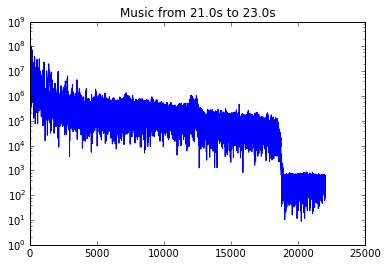

In [43]:
frequencies = np.arange(0, len(ffted_left)/2)
frequencies = frequencies * audiofile.frame_rate / len(ffted_left)
plt.plot(frequencies, np.abs(ffted_left)[0:len(ffted_left)/2]);
plt.yscale('log', nonposy='clip')
plt.title("Music from %.1fs to %.1fs" % (
        trumpets.start / audiofile.frame_rate,
        trumpets.stop / audiofile.frame_rate));

In [40]:
trumpets.stop

1014300

In [36]:
IPython.display.Audio(data_left, rate=audiofile.frame_rate)

In [18]:
data.shape

(19956528,)

In [21]:
import theano_lstm

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x10dab8f98>>
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 315, in __del__
    self.close()
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 433, in close
    self._ensure_header_written(0)
  File "/usr/local/Cellar/python3/3.4.3/Frameworks/Python.framework/Versions/3.4/lib/python3.4/wave.py", line 452, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


In [ ]:
theano_lstm.Layer(100, 